# Semantic Segmentation of Water using U-Net
# Part 4 - Data Augmentation


In this part I will build a larger training dataset by applying data augmentation techniques to the original images.

In [79]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import warnings
import re
import time

In [5]:
from unetlib.preprocessing import get_lakes_with_masks, make_dataframes_for_flow
import unetlib.visualisation as vs

In [3]:
# Imagery directories
nwpu_data_dir = 'nwpu_lake_images/data/'
nwpu_mask_dir = 'nwpu_lake_images/masks/'

In [4]:
# Split the test/train data
train_img_df, train_msk_df, test_img_df, test_msk_df, = make_dataframes_for_flow(nwpu_data_dir,
                                                                                 nwpu_mask_dir,
                                                                                 test_size=0.25,
                                                                                 random_state=42
                                                                                )

Data augmentations are any transformation that can be applied to the data (images in this case) to produce a new version of the data. These transformations can include flipping the image, zooming in/out, skewing, rotating etc.

The aim is to create new images that still look like the training data but have appropriate variation that one might expect in the real world. For example it makes sense to rotate and flip the lake images because they can exist in a huge range of shapes and sizes. On the other hand, consider OCR - flipping the images would flip the characters which then would lose meaning and not really represent the real world input data to the model.

These new images provide more data and more variation than the original dataset allowing the network to learn to generalise better. In this respect augmentation acts as a sort of regulariser.

To illustrate, I'll apply some random transformations to an image and show the output. The Pillow library contains useful functions for doing this.

In [117]:
# Select a random image
rand_img = train_img_df.sample(1)
rand_img_fn = os.path.join(nwpu_data_dir, rand_img.filename.squeeze())
print(rand_img_fn)

nwpu_lake_images/data/lake_265.jpg


Augmentations:
	Horizontal Flip: False
	Vertical Flip: False
	Rotation: 70


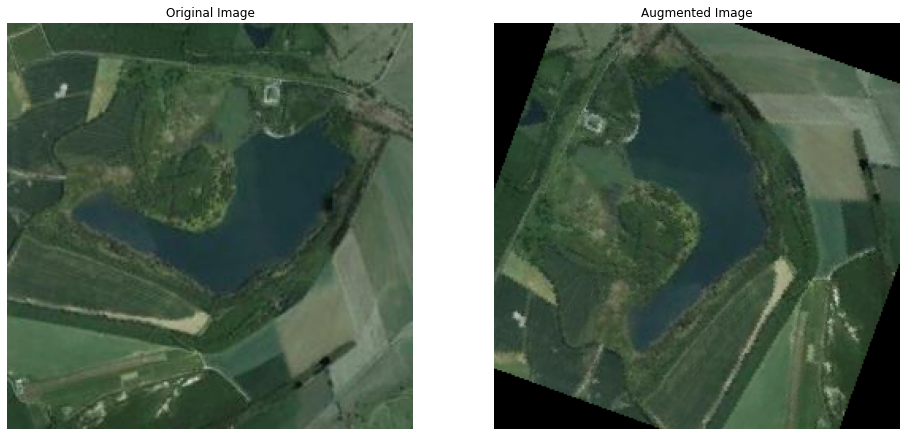

In [131]:
# Define a few augmentations
hflip = np.random.choice([True,False])
vflip = np.random.choice([True,False])
rot = np.random.choice(range(30,80,10))

print(f'Augmentations:\n\tHorizontal Flip: {hflip}'
      f'\n\tVertical Flip: {vflip}\n\tRotation: {rot}'
     )

# Open image
img = Image.open(rand_img_fn)

# Create axes and plot original
fig, axes = plt.subplots(1,2,figsize=(16,8))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')

# Apply augmentations
if hflip:
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
if vflip:
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
img = img.rotate(rot)

# Plot the augmented image
axes[1].imshow(img)
axes[1].axis('off')
axes[1].set_title('Augmented Image');

The resulting image looks like a reasonable training sample. Note that, the corresponding mask needs to have the same augmentations applied to ensure the correct ground truth labels are maintained.

Due to the rotation there is information loss at the edges of the new image; these pixels have been assigned a value of 0. To counter this, and avoid the network training on these values, the pixels are assigned a value based on the image e.g. nearest neighbour. Thankfully Keras has functionality that will streamline this process.

Recall from part 2 that the training and validation generators are configured using the `ImageDataGenerator class`. There are a range of parameters that this generate accepts and uses to apply augmentations such as those above. Previously I only used the `validation_split` parameter but I'll now expand this set up to include augmentations.

In [274]:
# Instantiate the data generator
datagen = ImageDataGenerator(validation_split=0.3,
                             rotation_range=90,
                             horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             zoom_range=0.25,
                             rescale=1/255.
                            )

In [275]:
# The image and mask flows are created in the same way as before
aug_train_img = datagen.flow_from_dataframe(train_img_df,nwpu_data_dir,subset='training',
                                            class_mode=None,shuffle=False, seed=42)
aug_train_msk = datagen.flow_from_dataframe(train_msk_df,nwpu_mask_dir,subset='training',
                                            class_mode=None, shuffle=False, seed=42)

Found 210 validated image filenames.
Found 210 validated image filenames.


In [276]:
# Get the first batch
aug_train_img_batch = aug_train_img.next()
aug_train_msk_batch = aug_train_msk.next()

In [270]:
def plot_batch(img_batch, n_images=None, n_cols=2, figsize=None):
    """
    """
    # Batches must be of dimensions N,H,W,C
    assert img_batch.ndim == 4    
      
    # Set number of rows to 1 per image/mask pair
    n_images = n_images or img_batch.shape[0]
    n_rows = int(np.ceil(n_images / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    for i, ax in zip(range(n_images), axes.ravel()):
        img = img_batch[i]
        
        ax.imshow(img)
        ax.axis('off')

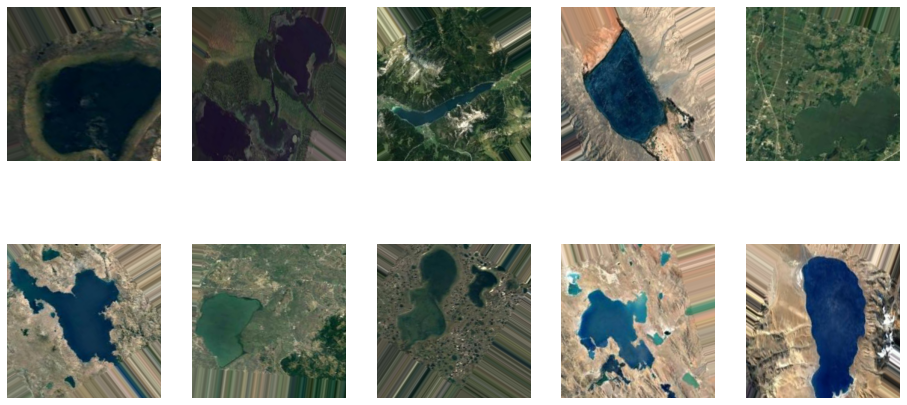

In [277]:
plot_batch(aug_train_img_batch, 10, 5, figsize=(16,8))

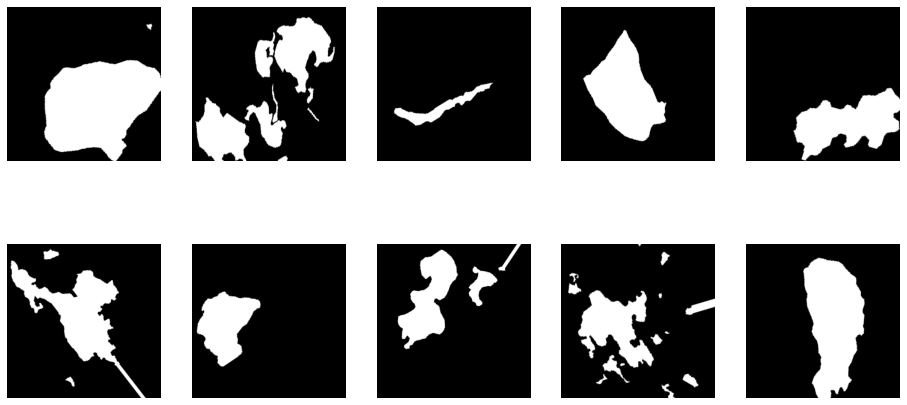

In [278]:
plot_batch(aug_train_msk_batch, 10, 5, figsize=(16,8))